# Practical #1: Sequence Alignment

### Importing a few useful things

In [559]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
from Bio.Align import substitution_matrices

BLOSUM62 = substitution_matrices.load("BLOSUM62")
BLOSUM50 = substitution_matrices.load("BLOSUM50")

### The code

Here, we will use the `class` formalism in Python. Classes are extremely useful and are often essential to writing well-designed code in Python. Here is the official documentation on Python classes: https://docs.python.org/3/tutorial/classes.html. In short, and according to that documentation, they bundle data and functionality together, making it easier to implement complex methods once, reusing them as often as we want and possibly with different data. 

The code below is a `class` that is initiated with two sequences and implements the global alignment between these two sequence, in addition to other functionality such as pretty-printing one traceback or all of them (recursively in the latter case).

In [702]:
class Align:
    def __init__(self, seqA, seqB):
        '''
        Initializes the class
        
        Inputs       | Desc.
        --------------------------------------------------
        seqA, seqB   | Strings (sequences) to be aligned
        
        '''
        self.seqA = seqA
        self.seqB = seqB
        self.lenA = len(seqA)
        self.lenB = len(seqB)
        
    def alignGlobal(self, gap_cost, score_matrix):  
        '''
        Aligns using the global (Needleman-Wunsch) alignment algorithm
        
        Inputs          | Desc.
        ---------------------------------------------------------------------------
        gap_cost        | gap penalty (linear, NOT affine)
        score_matrix    | Alignment scoring algorithm (ex: BLOSUM62)
        
        '''
        # initialize DP matrix
        self.dp_matrix = np.zeros((self.lenB + 1, self.lenA + 1))
        self.dp_matrix[0, :] = np.arange(0, -gap_cost * (self.lenA + 1), -gap_cost)
        self.dp_matrix[:, 0] = np.arange(0, -gap_cost * (self.lenB + 1), -gap_cost)
        
        # initialize traceback
        self.global_traceback = np.zeros((self.lenB + 1, self.lenA + 1))
        
        # initialize recursive traceback: the only difference is that each element is an object
        # that contains an array for all the possible "paths" to that element
        self.global_traceback_rec = np.zeros((self.lenB + 1, self.lenA + 1)).astype('object')
        
            
        # fill DP matrix
        for j in range(self.lenB + 1):
            for i in range(self.lenA + 1):
                # at (0,0), do nothing
                if j==0 and i==0: continue
                    
                # In the traceback matrix, 1 means "go to the left" (gap in sequence B)...
                elif j==0 and i>0:
                    self.global_traceback[j, i] = 1
                    self.global_traceback_rec[j, i] = np.array([1])
                    
                # ...and 2 means "go up" (gap in sequence A)
                elif j>0 and i==0:
                    self.global_traceback[j, i] = 2
                    self.global_traceback_rec[j, i] = np.array([2])
                
                # calculate the 3 scores (gap in A, gap in B, or pair) and find where the max comes from
                else:
                    possible_scores = np.array([self.dp_matrix[j-1, i-1] + score_matrix[self.seqA[i-1]][self.seqB[j-1]],
                                       self.dp_matrix[j, i-1] - gap_cost,
                                       self.dp_matrix[j-1, i] - gap_cost])
                    self.dp_matrix[j, i] = np.max(possible_scores)
                    self.global_traceback[j, i] = np.argmax(possible_scores)
                    self.global_traceback_rec[j, i] = np.argwhere(possible_scores == np.max(possible_scores)).flatten()

        
    def printAlignment(self, method):
        '''
        "simple" for one traceback
        "recursive" for all tracebacks possible
        
        '''
        if method == "simple": 
            self.tracebackSimple(self.global_traceback)
        elif method == 'recursive':
            self.tracebackRec(self.global_traceback_rec)
        
    def tracebackOneStep(self, pos, direction):
        '''
        Helper function that returns the tuple: 
        
        ((seqA symbol, identity symbol, seqB symbol), (new_i, new_j))
        \------------------v----------------------/  \-----v------/
        alignment tuple in easily readable format     new position  
        
        This format is for better design and reduced redundancy. It can be used in many other
        places in this class, which makes the code simpler to understand.
        
        '''
        i, j = pos
        
        # 0 means there is a pairing
        if direction == 0:
            return ((self.seqA[i-1], ":" if  self.seqA[i-1] == self.seqB[j-1] else " ", self.seqB[j-1]), 
                    (i-1, j-1))

        # 1 means sequence B is gapping
        elif direction == 1:
            return ((self.seqA[i-1], " ", "-"), 
                    (i-1, j))
            
        # 2 means sequence A is gapping
        elif direction == 2:
            return (("-", " ", self.seqB[j-1]), 
                    (i, j-1))
        
    def printTracebackTuples(self, tuples):
        '''
        Simply prints the alignment tuples above in a nice way. Example:
        
        HEAGAWGHEE  <-- Sequence A
            ::   :  <-- Identities
        --P-AWHEAE  <-- Sequence B
        
        '''
        print(('').join([x[0] for x in tuples][::-1]))
        print(('').join([x[1] for x in tuples][::-1]))
        print(('').join([x[2] for x in tuples][::-1]))
        

    def tracebackSimple(self, traceback_matrix):
        '''
        Simple traceback to find one possible traceback (even if alignment is ambiguous).
        This function uses the helper functions above.

        '''
        # init list of traceback steps
        steps = []
        
        # start from the bottom right corner
        i,j = self.lenA, self.lenB
        
        self.position_tracker = [(i, j)]
        
        while j > 0 or i > 0:
                step, new_pos = self.tracebackOneStep((i, j), traceback_matrix[j, i])
                i, j = new_pos
                self.position_tracker.append(new_pos)
                steps.append(step)
        
        # print in an easily readable way
        self.printTracebackTuples(steps)
        
            
    def tracebackRec(self, traceback_matrix):
        '''
        Recursive traceback to find all possible tracebacks in an ambiguous alignment
        
        '''
        
        def traceback_rec(pos, traceback_list, positions_list):
            if pos == (0,0): # base case
                return [traceback_list], [positions_list]
            else:            # acid case
                i, j = pos
                placeholder = []
                placeholder_pos = []
                for direction in traceback_matrix[j, i]:
                    step, new_pos = self.tracebackOneStep(pos, direction)
                    tbck_holder, pos_holder = traceback_rec(new_pos, traceback_list + [step], positions_list + [new_pos])
                    placeholder += tbck_holder
                    placeholder_pos += pos_holder
                return placeholder, placeholder_pos
        
        # start from the bottom right corner
        self.recursive_tracebacks, self.recursive_positions = traceback_rec((self.lenA, self.lenB), [], [(self.lenA, self.lenB)])
        
        # print resulting alignments
        for idx, alignments in enumerate(self.recursive_tracebacks):
            print("#" + str(idx))
            self.printTracebackTuples(alignments)
            print("")
        
        

### A quick demonstration

In [703]:
seqA = "HEAGAWGHEE"
seqB = "PAWHEAE"

example = Align(seqA, seqB)


In [704]:
example.alignGlobal(gap_cost = 8, 
                    score_matrix = BLOSUM62)

In [705]:
example.printAlignment(method = "simple")

HEAGAWGHEE
    ::   :
--P-AWHEAE


In [707]:
example.printAlignment(method = "recursive")

#0
HEAGAWGHEE
    ::   :
--P-AWHEAE

#1
HEAGAWGHEE
    ::   :
-P--AWHEAE

#2
HEAGAWGHEE
  :  :   :
-PA--WHEAE

#3
HEAGAWGHE-E
    :: :: :
--P-AW-HEAE

#4
HEAGAWGHE-E
    :: :: :
-P--AW-HEAE

#5
HEAGAWGHE-E
  :  : :: :
-PA--W-HEAE



### Visualizing things...

"Like good scientists!"

This works with any sequence input, but you will have to rerun the alignment code after changing `seqA` and `seqB` if you want to see a difference in the plot. I could have added this as a function (attribute) to the `class Align` above, but chose not to do so to keep things a little simpler (and code cells a little shorter).

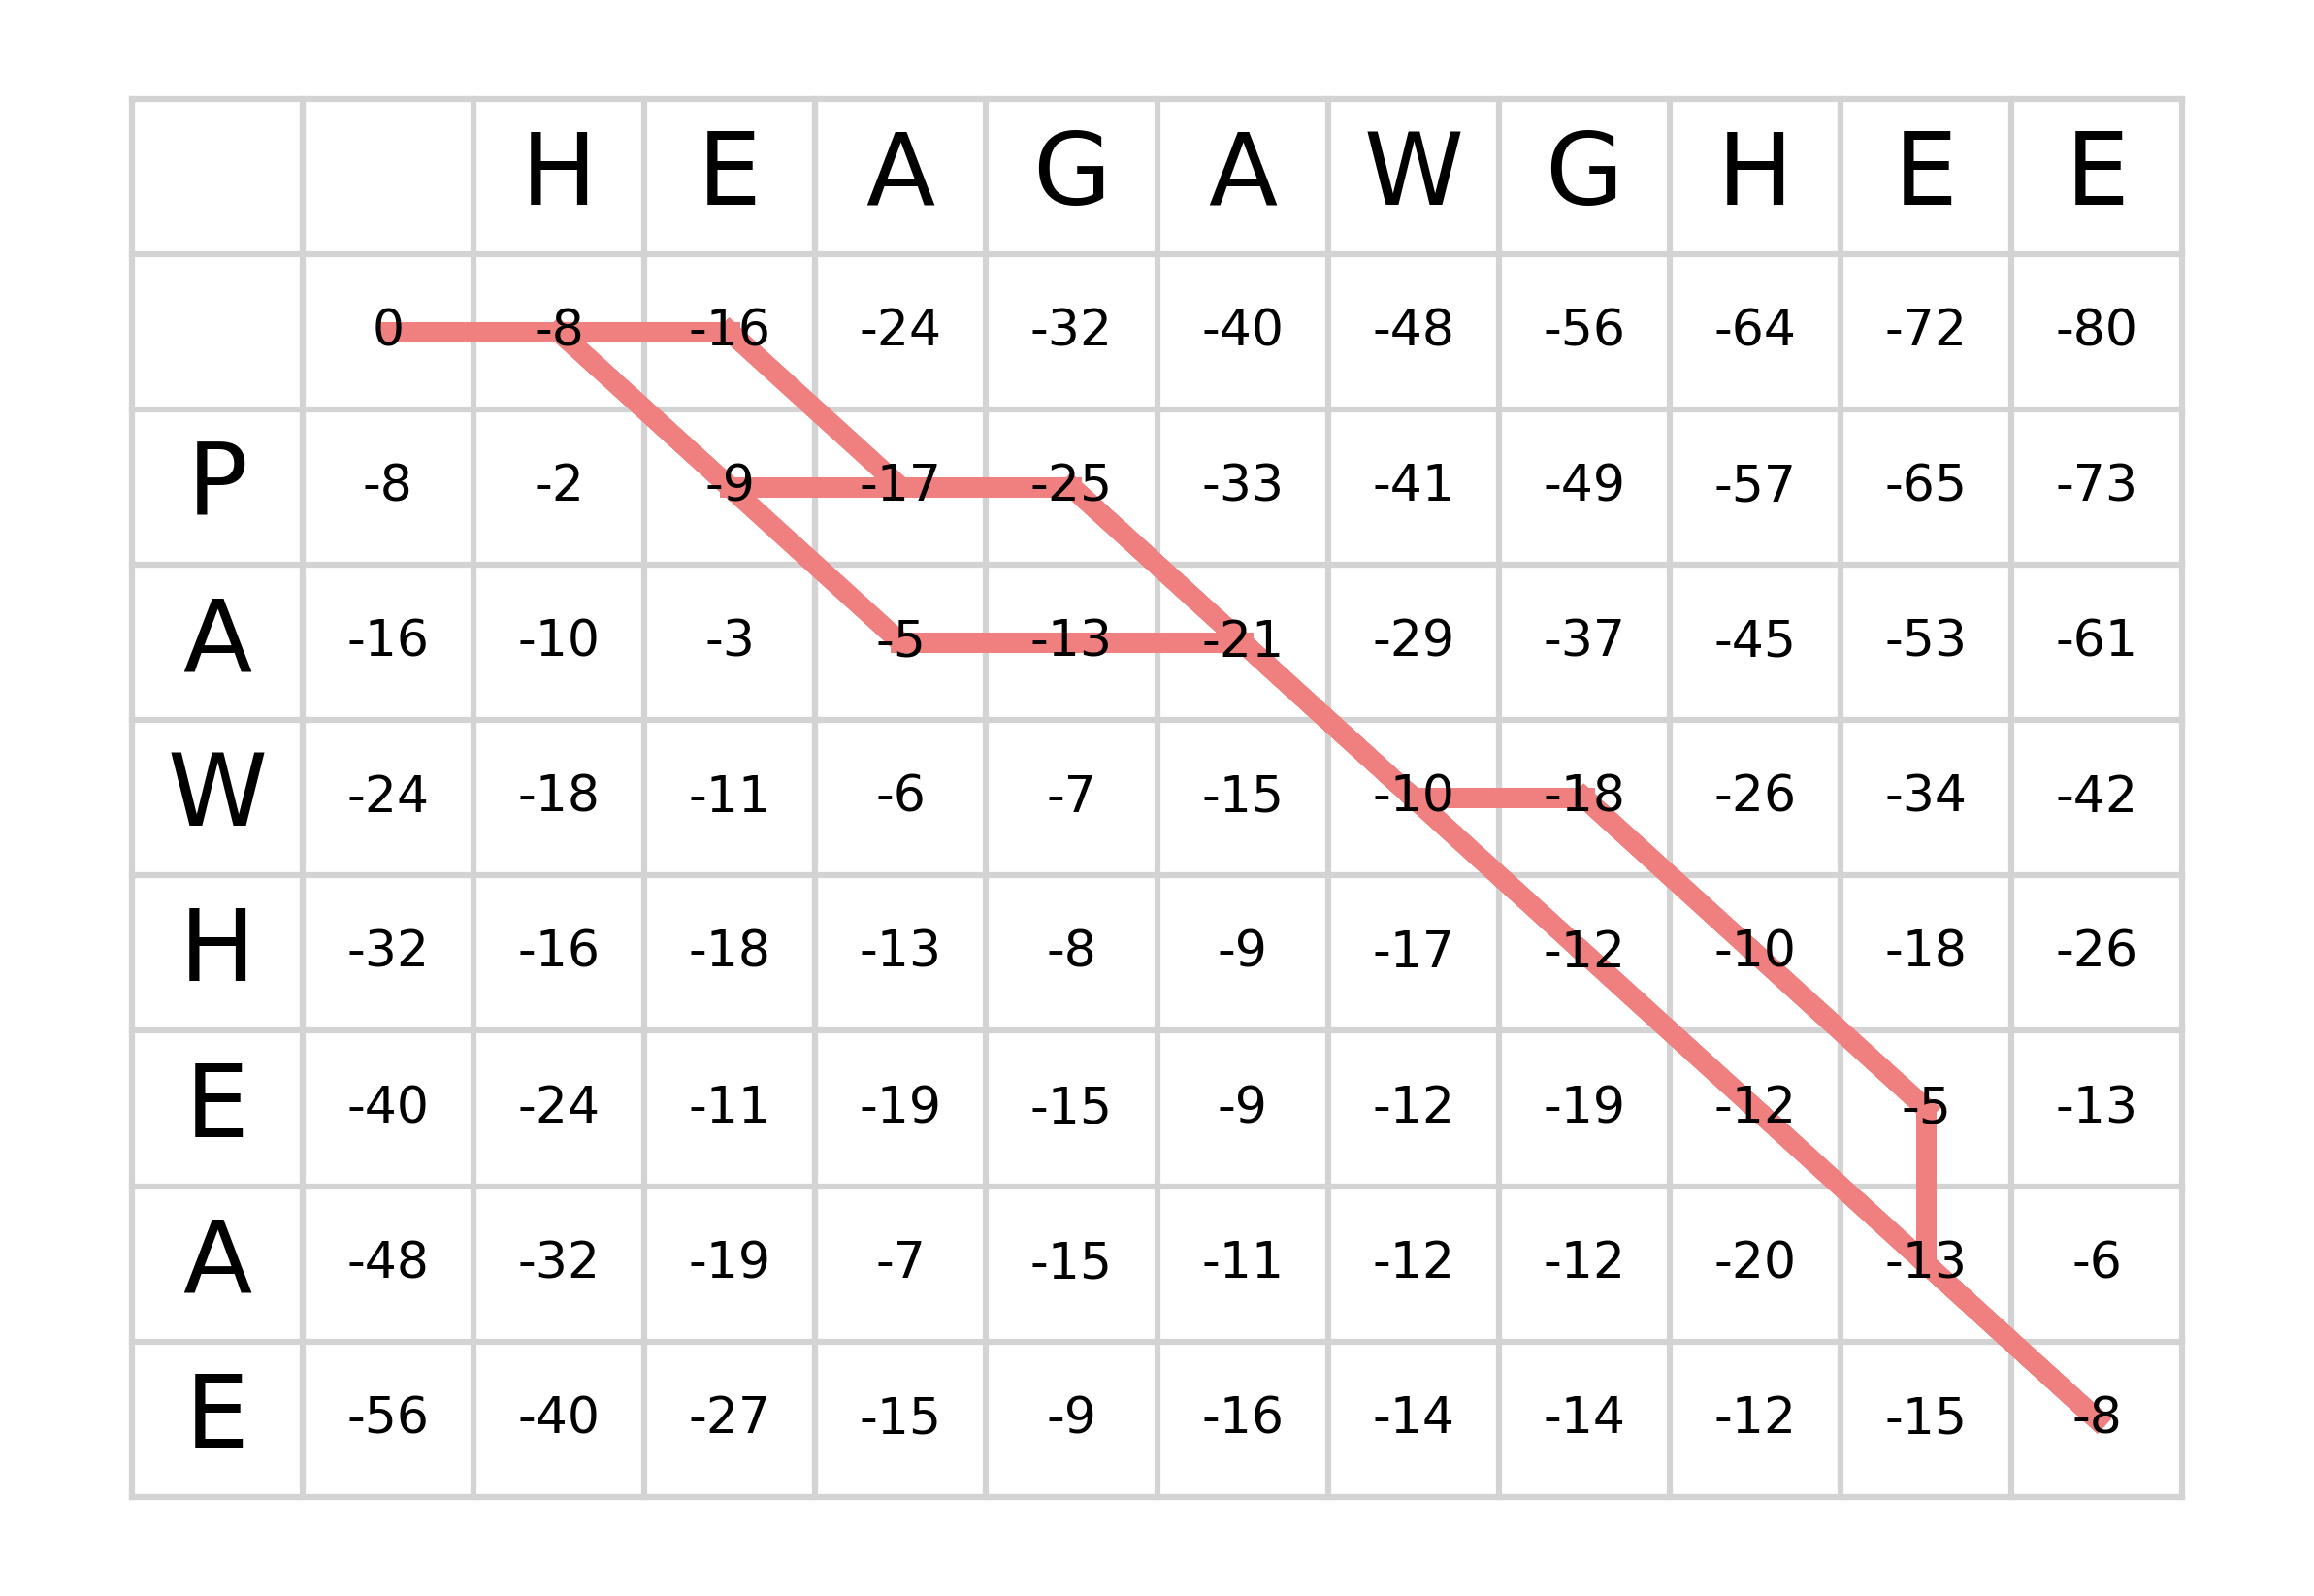

In [708]:
lenA, lenB = len(seqA), len(seqB)
mat = example.dp_matrix
tbmat = example.global_traceback
tracker = example.recursive_positions

# to make sure that the longest sequence is always horizontal
if lenA > lenB: 
    seqTop, seqLeft = seqA, seqB
else: 
    seqTop, seqLeft = seqB, seqA
    mat = mat.T
    tbmat = tbmat.T

# initializing figure
fig, ax = plt.subplots(1, dpi=300, figsize=(10, 10*(len(seqLeft)/len(seqTop))))
ax.axis('off')
ax.set_xticks([]); ax.set_yticks([]);


# creating a grid for easier (and better-designed) code
topRange = np.linspace(0, 1, len(seqTop)+3)
leftRange = np.linspace(0, 1, len(seqLeft)+3)
textGridX, textGridY = np.meshgrid((topRange[:-1]+topRange[1:])/2, 
                                   (leftRange[:-1]+leftRange[1:])/2)
textGridY = np.flipud(textGridY)

# drawing the table borders
for w in topRange: ax.plot([w,w],[0,1], color = 'lightgrey')
for h in leftRange: ax.plot([0,1],[h,h], color = 'lightgrey')

# making font size dynamic (heuristically)
size = 250/len(seqTop)

# writing in the top sequence
topTextX, topTextY = textGridX[0, 2:], textGridY[0, 2:]
for idx, s in enumerate(seqTop):
    ax.text(topTextX[idx], topTextY[idx], s, ha='center', va='center', size = size)

# writing in the left sequence
leftTextX, leftTextY = textGridX[2:, 0], textGridY[2:, 0]
for idx, s in enumerate(seqLeft):
    ax.text(leftTextX[idx], leftTextY[idx], s, ha='center', va='center', size = size)
    
# writing in the DP matrix
for j, i in np.ndindex(mat.shape):
    ax.text(textGridX[j+1, i+1], textGridY[j+1, i+1], str(int(mat[j, i])), 
            ha='center', va='center', size = size/2)

# plotting the tracebacks
def plotTraceback(positions):
    for idx, pos in enumerate(positions[:-1]):
        i,j = pos
        i_, j_ = positions[idx+1]
        ax.plot([textGridX[j+1, i+1], textGridX[j_+1, i_+1]], [textGridY[j+1, i+1], textGridY[j_+1, i_+1]], 
                color = 'lightcoral', lw = 5)

for track in tracker:
    plotTraceback(track)

You can match the red tracebacks with the text output in the previous section. Spoiler: they match!